This notebook closely follows the [benchmark notebook](https://www.drivendata.co/blog/mars-spectrometry-benchmark/) provided by the competition organizors. It will serve as a starting point in understanding the problem.

# Environment

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Change main system path to be able to run code from src folder
import sys
p = sys.path[0]
# Mac OS
if sys.path[0].endswith('/notebooks'):
    main_path = p[:-len('/notebooks')]
if sys.path[0].endswith('/techdoc/content'):
    main_path = p[:-len('/techdoc/content')]
    
# Windows OS
if sys.path[0].endswith('\\notebooks'): 
    main_path = p[:-len('\\notebooks')]
if sys.path[0].endswith('\\techdoc\content'): 
    main_path = p[:-len('\\techdoc\content')]

sys.path[0] = main_path

In [3]:
import gc, itertools
from termcolor import colored
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from src import (config, describe_data, features,
                 preprocess, training)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# LOADING THE DATA

In [4]:
metadata = pd.read_csv(config.DATA_DIR + 'metadata.csv')
print(f'Metadata: {metadata.shape}')

train_labels = pd.read_csv(config.DATA_DIR + 'train_labels.csv')
print(f'Train labels: {train_labels.shape}')

submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv')
print(f'Submission: {submission.shape}')

Metadata: (1570, 5)
Train labels: (766, 11)
Submission: (804, 11)


In [5]:
#Check whether the samples are unique in the table.
print(metadata.sample_id.nunique() == metadata.shape[0])

True


In [6]:
metadata.head()

,sample_id,split,instrument_type,features_path,features_md5_hash
0,S0000,train,commercial,train_features/S0000.csv,017b9a71a702e81a828e6242aa15f049
1,S0001,train,commercial,train_features/S0001.csv,0d09840214054d254bd49436c6a6f315
2,S0002,train,commercial,train_features/S0002.csv,3f58b3c9b001bfed6ed4e4f757083e09
3,S0003,train,commercial,train_features/S0003.csv,e9a12f96114a2fda60b36f4c0f513fb1
4,S0004,train,commercial,train_features/S0004.csv,b67603d3931897bfa796ac42cc16de78


In [7]:
metadata.split.value_counts()

train    766
test     511
val      293
Name: split, dtype: int64

In [8]:
metadata.instrument_type.value_counts()

commercial     1494
sam_testbed      76
Name: instrument_type, dtype: int64

Get the file paths from the 'metadata' and save them as dictionaries, where the key will be a value from 0 onwards.

In [8]:
train_files = metadata[metadata.split == 'train']['features_path'].to_dict()
valid_files = metadata[metadata.split == 'val']['features_path'].to_dict()
test_files = metadata[metadata.split == 'test']['features_path'].to_dict()

In [9]:
train = metadata[metadata.split == 'train'].copy().reset_index(drop=True)
print(f'TRAIN: {train.shape}')
valid = metadata[metadata.split == 'val'].copy().reset_index(drop=True)
print(f'VALID: {valid.shape}')
test = metadata[metadata.split == 'test'].copy().reset_index(drop=True)
print(f'TEST: {test.shape}')

TRAIN: (766, 5)
VALID: (293, 5)
TEST: (511, 5)


# LEARNING ABOUT THE PROBLEM

## Goals and Objectives

- **goal**: detect the presence of certain families of chemical compounds in geological material samples using EGA data collected from Mars exploration missions.

The data is based on the EGA mass spectrograms from two different instruments, namely 'commercial' and 'sam_testbed':
- **Commercial instruments**: the data comes from commercially manufactured instruments that have been configured as SAM analogs at the Goddard and Johnson labs
- **SAM testbed**: the data comes from the SAM testbed at Goddard, a replica of the SAM instrument suite on Curiosity

**Data from these two instruments differ in many ways** - see [Problem Description Page](https://www.drivendata.org/competitions/93/nasa-mars-spectrometry/page/438/).
- Commercial instruments measure ion abundance as ion current in amps (Coulombs per second), while the SAM testbed measures abundance as counts per second. This results in their respective samples having drastically different orders of magnitude for their abundance values. As noted in the previous section, however, the key idea is to compare relative abundance values within one sample's run, and not to compare absolute abundance values across samples.
- Commercial instrument runs will have ion abundance measurements for all m/z values at every timestep of measurement. The SAM testbed can only measure abundance for one m/z value at a time—the mass spectrometer scans across m/z values in ascending order and cycles through its range of detection.
- Commercial instrument runs were generally configured to collect data for whole number m/z values from 0.0 to 100.0. The SAM testbed detects ions for a larger range of m/z values, up to 534.0 or 537.0, and data sometimes includes fractional m/z values.
    - In general, ions relevant to the detection of the label classes for this competition will be within the 0.0–100.0 range.
    - In general, if fractional m/z abundances are significant, they will be highly correlated to those of the nearest whole number m/z, e.g., m/z=1.9 will be highly correlated with 2.0. For EGA data, it is generally enough to only look at the whole number m/z values and ignore the fractional m/z values.

## Sample Analysis at Mars ([SAM](https://mars.nasa.gov/msl/spacecraft/instruments/sam/for-scientists/))
- SAM is an instrument suite aboard the Curiosity rover on Mars.
- takes up more than half of the science component load on the rover
- has 6 components: gas chromatograph, mass spectrometer, tunable laser spectrometer, sample manipulation system, sensitivity, and ovens.
- The *mass spectrometer* separates elements and compounds by mass for identification and measurement.

## Mass Spectrometry

What is mass spectrometry? [Khan Academy](https://www.khanacademy.org/science/ap-chemistry-beta/x2eef969c74e0d802:atomic-structure-and-properties/x2eef969c74e0d802:mass-spectrometry-of-elements/v/mass-spectrometry)

- isotope: different version of an element; can have different atomic mass
    - same number of protons but different number of neutrons
- the process:
    - get a sample
    - heat it up so that the sample starts floating around
    - bombard it with electrons, to knock off electrons from the sample and it will ionize some of the atoms, which now have charge
    - because they have charge they can be accelerated through the electric plates
    - enter into a strong magnetic field, which can bend their path. The bending depends on their mass, lower -> deflected more, and vice versa
    - detector is at the end which measures where they land and we can see which isotopes we have the most in nature.

- 'm/z': mass to charge ratio, where charge is the charge of the ions. If the charge is 1 then m/z is the same as the atomic mass. You need to adjust is it is not in atomic mass.
- the relative **abundance** of an isotope is the percentage of atoms with a specific atomic mass found in a naturally occurring sample of an element. It is determined, for each isotope, using mass spectrometry.
- because isotopes contain different numbers of neutrons, each isotope has a unique atomic mass.
- **atomic mass**: 1u=1/12

## Data Description

**Labels**:
1. Basalt
2. Carbonate
3. Chloride
4. Iron Oxide
5. Oxalate
6. Oxychlorine (chlorate, perchlorate)
7. Phyllosilicate
8. Silicate
9. Sulfate
10. Sulfide

Let's check the distribution of the target variables. First we sum all the target variables to see if this is a multiclass or multilabel problem. Then we analyze the distribution of the target labels.

We get that the targets can be multiple so this is a multilabel classification problem. Let's plot the distribution of target labels.

In [12]:
target_sum = train_labels.sum(axis=1, numeric_only=True)
all(target_sum == 1)

False

Get the sum for each target label in the sample:

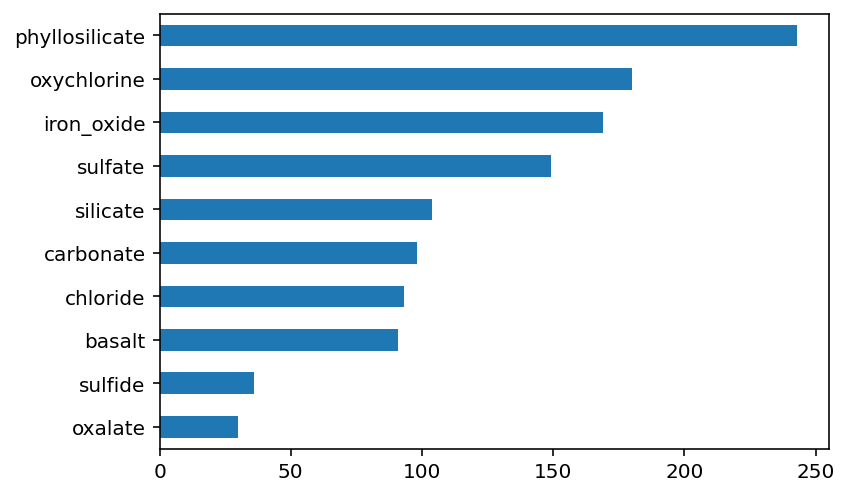

In [13]:
train_labels.sum(axis=0, numeric_only=True).sort_values().plot(kind='barh')
plt.show()

In [12]:
# Get the names of the target columns in a list
target_labels_list = [i for i in train_labels.columns if i not in ['sample_id']]
print(target_labels_list)

['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']


In [13]:
# Check to see if all rows have assigned at least one label
train_labels['DQ'] = train_labels[target_labels_list].sum(axis=1)
train_labels['no_label'] = np.where(train_labels['DQ'] ==  0, 1, 0)
del train_labels['DQ']
train_labels.head(2)


,sample_id,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide,no_label
0,S0000,0,0,0,0,0,0,0,0,1,0,0
1,S0001,0,1,0,0,0,0,0,0,0,0,0


In [91]:
# Refresh the target labels list
target_labels_list = [i for i in train_labels.columns if i not in ['sample_id']]
print(target_labels_list)

['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']


In [17]:
#TODO WHat are each of these compounds - how do they relate - can this be a feature from the target

Let's analyze the distribution properties of each label separately to see the class imbalance within each label. It is clear from the graphs below that each target is highly imbalanced. 

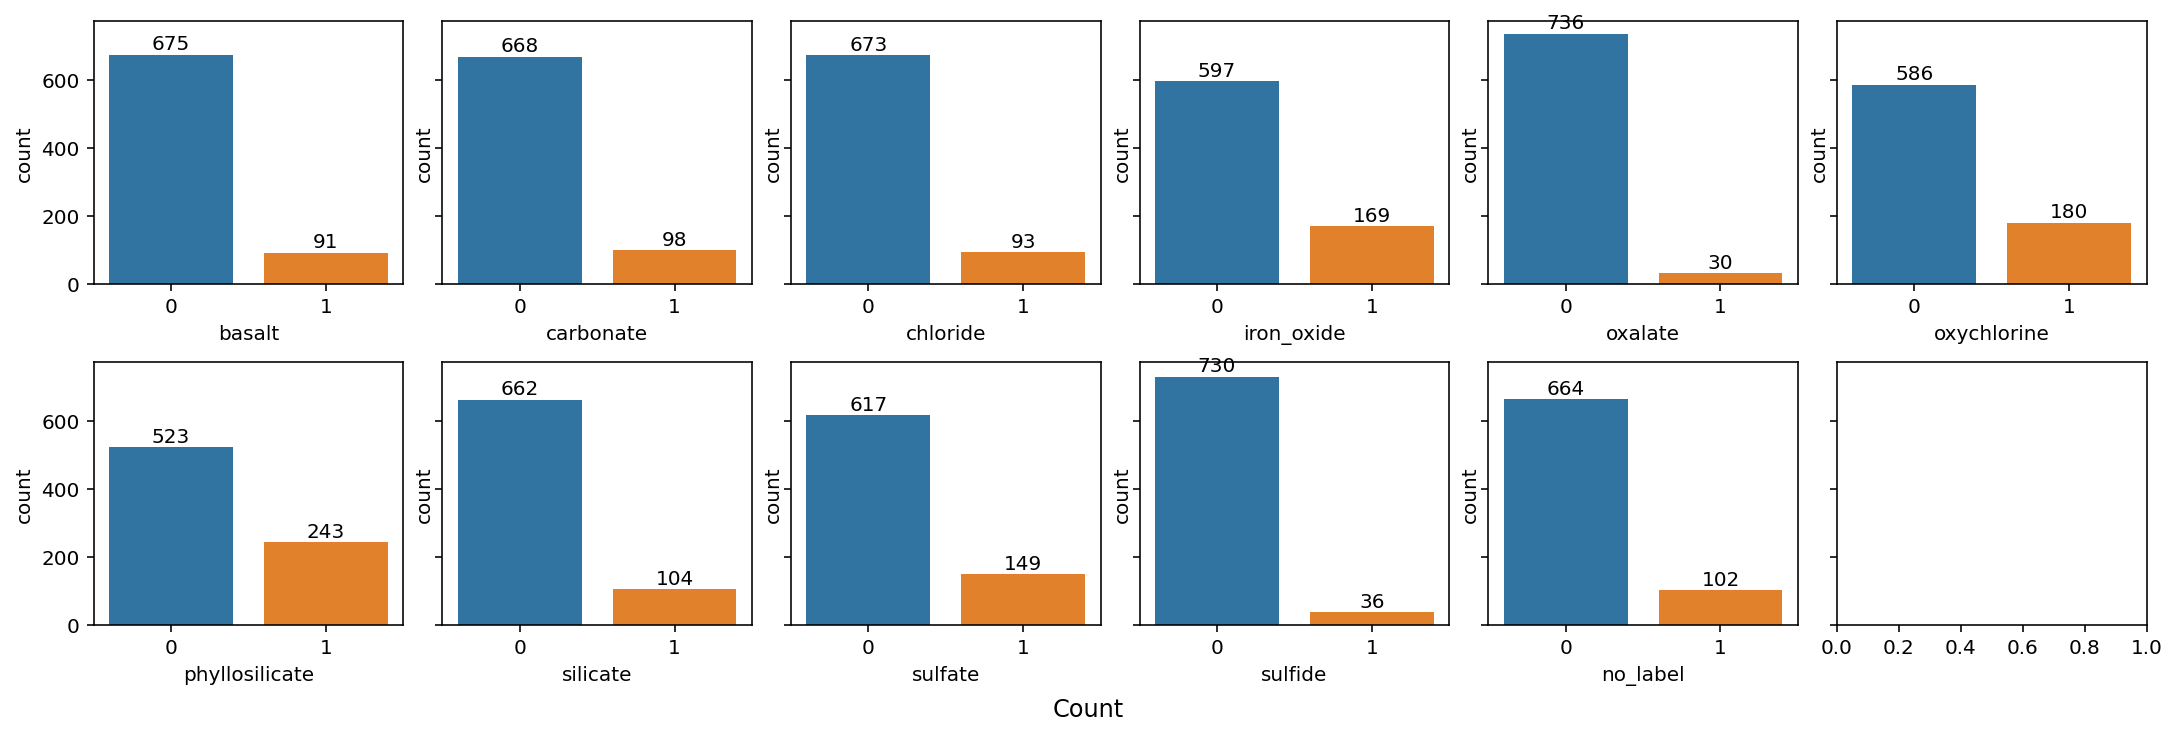

In [18]:
fig, ax = plt.subplots(2, 6, 
                       figsize=(15,5),
                       constrained_layout=True, 
                       sharey="all")
#fig.supylabel('Temperature')
fig.supxlabel('Count')
#fig.suptitle('Commercial')

for n,target in enumerate(target_labels_list):
    plt.subplot(2, 6, n+1)
    # Draw a countplot
    scp = sns.countplot(x = target,
                        data = train_labels)
    
    # Add label values to the plot
    describe_data.annotate_countplot(scp, train_labels, 0.02)
    
plt.show()

Let's combine all the labels for each sample in a list and save as a column in a `train_labels` dataframe.

In [15]:
# Combine target labels in a list for each sample
labels_list = {}
for i in train_labels.index:
    ht = pd.DataFrame(train_labels.iloc[i][target_labels_list] == 1)
    labels_list[i] = ht[ht[i] == True].index.values

# Map back to the initial table
train_labels['target'] = train_labels.index.map(labels_list)

**Features** of the samples are given by:
- `time` - Time in seconds since start of a reference time - start of the experiment.
- `temp` – Temperature of the sample in ºC at time of the measurement.
- `m/z` – Mass-to-charge ratio of ion being measured; "type" of ion detected.
- `abundance` – Rate of ions detected, per second. Typically, all abundance values are compared in a relative way within one sample's analysis run. (Note that different samples will have abundances in different units, discussed more later.)

In [20]:
# Get the file path of a sample
fp = metadata.iloc[0,3]
print(fp)

# Load the sample data
ht = pd.read_csv(config.DATA_DIR + fp)
print(ht.shape)
ht.head()

train_features/S0000.csv
(38600, 4)


,time,temp,m/z,abundance
0,0.0,35.289,0.0,5.550957e-11
1,0.0,35.289,1.0,5.318589e-11
2,0.0,35.289,2.0,2.040361e-11
3,0.0,35.289,3.0,3.989464e-11
4,0.0,35.289,4.0,1.594648e-08


# CROSS VALIDATION

Let's set up the cross validation strategy before going further. Each experiment or sample in this problem can be considered independent from another. Time component is inherent within each sample but not across the training data. The sample is rather small so we can not have many folds cross validation. We will try to set up the validation scheme on a 5-fold strategy.

We define a new column `kfold` for cross validation, where the i-th fold will be used for validation and the rest for training. There are 358 label combinations. Since there are only 766 observations in the training sample we can not perform stratification on all label combinations. We can see that the majority of labels are single per observation, so we can perhaps try to stratify based on the main labels and all other combine into one label for the purposes of cross validation method.

To ensure proper testing of the SAM testbed observations we will also stratify given the `instrument` type to ensure that we get SAM testbed observation in the train and valid datasets.

## Target Analysis

Create column `target_single` where the label `multi` is given for multilabel target, and single label targets are taken as is.

In [16]:
# Create a combined target column
train_labels['target_single'] = [i[0] if len(i) == 1 else "multi" for i in train_labels.target]
train_labels.head()

,sample_id,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide,no_label,target,target_single
0,S0000,0,0,0,0,0,0,0,0,1,0,0,[sulfate],sulfate
1,S0001,0,1,0,0,0,0,0,0,0,0,0,[carbonate],carbonate
2,S0002,0,0,0,0,0,1,0,0,0,0,0,[oxychlorine],oxychlorine
3,S0003,0,1,0,1,0,0,0,0,1,0,0,"[carbonate, iron_oxide, sulfate]",multi
4,S0004,0,0,0,1,0,1,1,0,0,0,0,"[iron_oxide, oxychlorine, phyllosilicate]",multi


<AxesSubplot:>

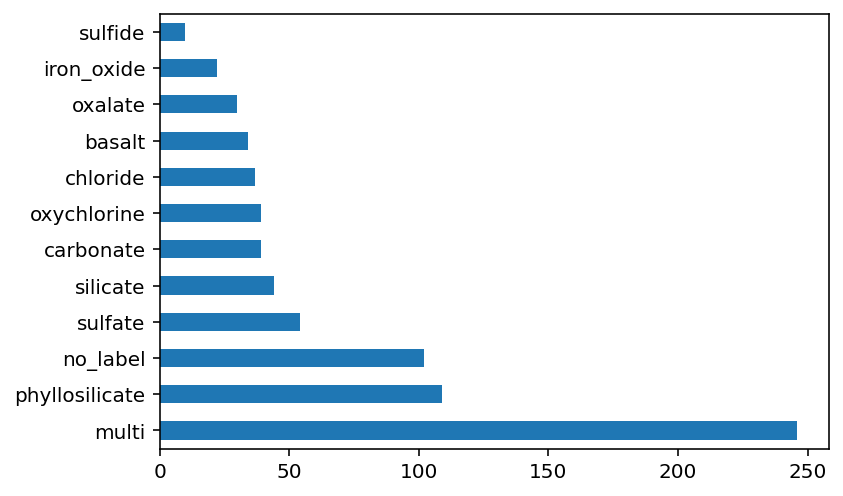

In [22]:
train_labels.target_single.value_counts().plot(kind='barh')

How do they relate to the instrument type?

In [23]:
metadata = pd.merge(metadata, train_labels[['sample_id', 'target', 'target_single']], on='sample_id', how='left')
metadata.head()

,sample_id,split,instrument_type,features_path,features_md5_hash,target,target_single
0,S0000,train,commercial,train_features/S0000.csv,017b9a71a702e81a828e6242aa15f049,[sulfate],sulfate
1,S0001,train,commercial,train_features/S0001.csv,0d09840214054d254bd49436c6a6f315,[carbonate],carbonate
2,S0002,train,commercial,train_features/S0002.csv,3f58b3c9b001bfed6ed4e4f757083e09,[oxychlorine],oxychlorine
3,S0003,train,commercial,train_features/S0003.csv,e9a12f96114a2fda60b36f4c0f513fb1,"[carbonate, iron_oxide, sulfate]",multi
4,S0004,train,commercial,train_features/S0004.csv,b67603d3931897bfa796ac42cc16de78,"[iron_oxide, oxychlorine, phyllosilicate]",multi


In [24]:
pd.crosstab(metadata.instrument_type, metadata.target_single)

target_single,basalt,carbonate,chloride,iron_oxide,multi,no_label,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
instrument_type,,,,,,,,,,,,
commercial,34,39,37,22,245,93,30,38,108,44,54,10
sam_testbed,0,0,0,0,1,9,0,1,1,0,0,0


As we can see from the above table there are almost no single targets in the SAM testbed dataset.

## CV Strategy

**Option 1**: StratifiedKFold for each label and fit each label   
**Option 2**: Fit a multilabel model and incorporate CV inside

# EXPLORATORY DATA ANALYSIS

## Instrument type

What proportion of instrument type do we have in the train, valid, and test samples? We get the column percentages with `pd.crosstab()` function and the argument `normalize='index'` to get the percentage by rows. We can see from the table below that the most commercial instrument is present in the train set, while in the majority of the SAM measurments are in the test set. Interestingly, there are no SAM measurements in the `val` dataset.

> In this competition, it is expected that modeling the SAM testbed data will be difficult, and that there will need to be transfer learning from the commercial instrument data in order to successfully model the SAM testbed data. 

> The top performers on the SAM testbed samples within the test set will be invited to submit a report of their methodology, to be judged by a panel of experts from NASA. 
([Ref](https://www.drivendata.co/blog/mars-spectrometry-benchmark/))

In [25]:
#TODO Define the testing of the model on the whole sample using the CV and then separately on the commercial vs SAM instrument.  
#TODO Can it be done to model on commercial only and do a transfer learning on the SAM instrument.

In [26]:
pd.crosstab(metadata.split, metadata.instrument_type, margins=True)

instrument_type,commercial,sam_testbed,All
split,,,
test,447,64,511
train,754,12,766
val,293,0,293
All,1494,76,1570


In [27]:
pd.crosstab(metadata.split, metadata.instrument_type, normalize='index')

instrument_type,commercial,sam_testbed
split,,
test,0.874755,0.125245
train,0.984334,0.015666
val,1.000000,0.000000


## Exploring Features

### Time vs. Temperature

- temperature is suppose to be a function of time in the experiments
- patterns of ions may vary as a function of both time and temperature
- instrument type may contain different ranges of times and temperatures

In [28]:
#TODO how to incorporate the fact that testbeds has some non-linear heating profiles...
# there may be nuances to how the sample was heated over time that provides additional information.

Let's visually explore the relationship between `time` and `temperature` for both types of instruments. We will pick at random 5 samples for each and plot them.

In [29]:
# Randomly select 5 samples from each instrument
sample_com = metadata[(metadata.instrument_type == 'commercial') & (metadata.split == 'train')]['sample_id'].sample(n=5).index
sample_sam = metadata[(metadata.instrument_type == 'sam_testbed') & (metadata.split == 'train')]['sample_id'].sample(n=5).index

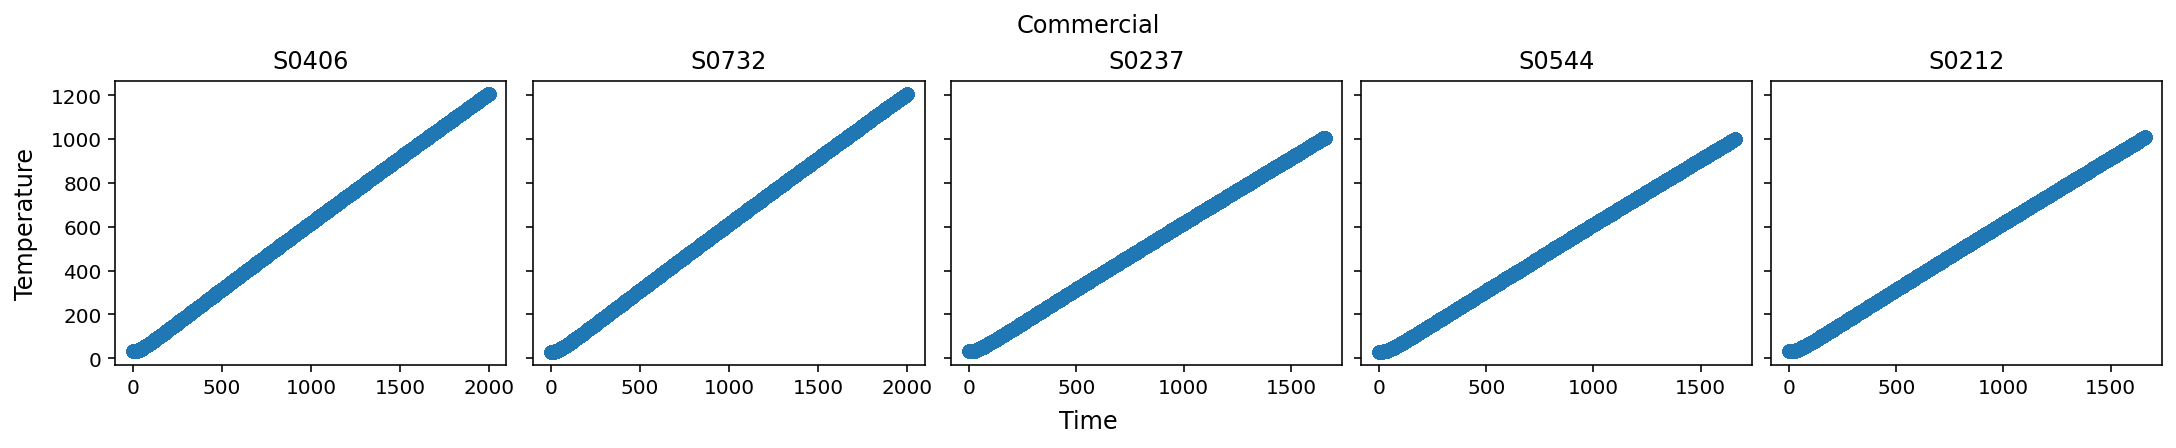

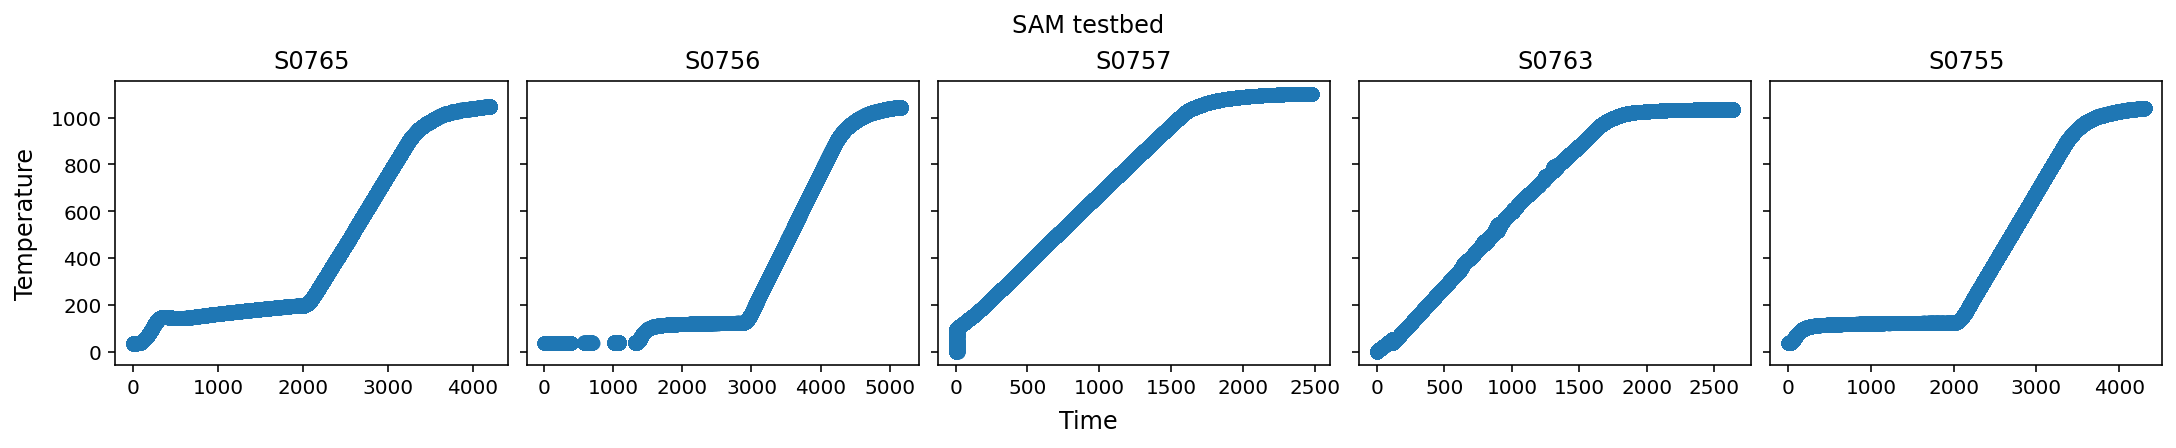

In [30]:
fig, ax = plt.subplots(1, len(sample_com), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Temperature')
fig.supxlabel('Time')
fig.suptitle('Commercial')

for n,i in enumerate(sample_com):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    plt.scatter(df['time'], df['temp'])
    plt.title(sample_name)
plt.show()
    
fig, ax = plt.subplots(1, len(sample_sam), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Temperature')
fig.supxlabel('Time')
fig.suptitle('SAM testbed')

for n,i in enumerate(sample_sam):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    plt.scatter(df['time'], df['temp'])
    plt.title(sample_name)
plt.show()
    

From the graphs above we can see that the sample have similar structure of temperature increase given time, where the max values is about 1000 degrees over a period of 1600 seconds. However, we can see that there is a difference in structure between the two instruments, where the SAM testbed has more of a non-linear structure.

### Type of Ion vs Abundance

Type of ion is given by `m/z` where the abundance, or the ion's type levels across time and temperature, is given by `abundance`. Let's try to visualize the abundance by the type of ions given temperature.

- different ion types peak at different temperatures
- there are some ions that are constantly high is value -> `m/z=4` helium carrier gas (not from the sample)
- there are ion types consistently in low value - likely background abundances and should be neglected.

> Spectrogram is useful for the peaks in abundances it shows at different temperatures and times.

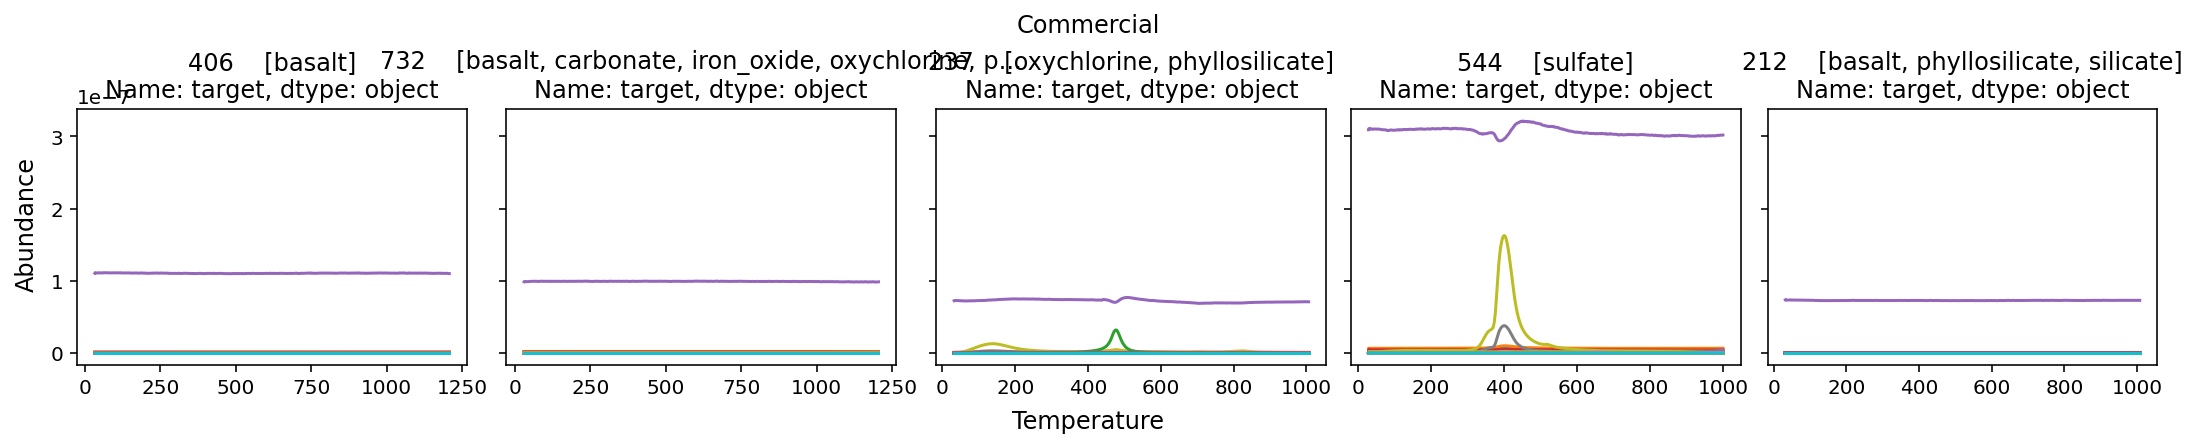

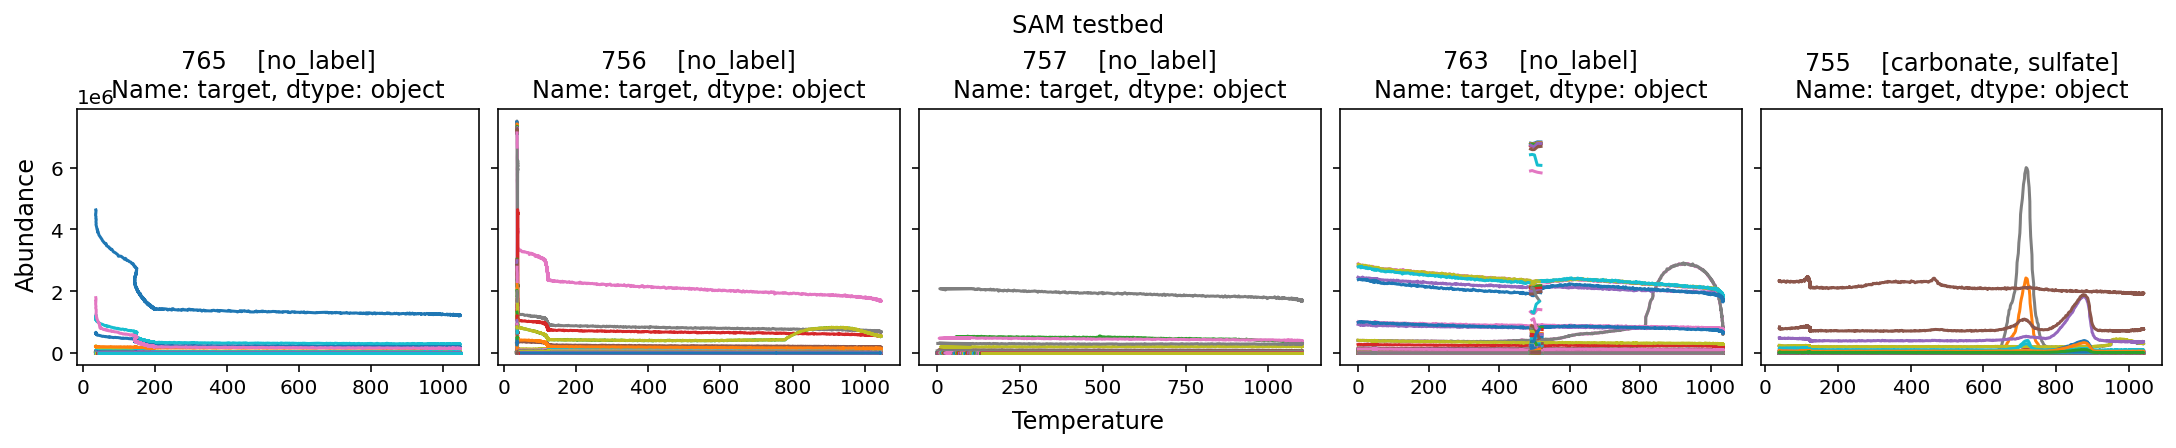

In [31]:
fig, ax = plt.subplots(1, len(sample_com), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Abundance')
fig.supxlabel('Temperature')
fig.suptitle('Commercial')

for n,i in enumerate(sample_com):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    target = train_labels[train_labels.sample_id == sample_name]['target']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    for i in df['m/z'].unique():
        ht = df[df['m/z'] == i]
        plt.plot(ht['temp'], ht['abundance'])
    plt.title(str(target))
plt.show()

del ht

fig, ax = plt.subplots(1, len(sample_sam), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Abundance')
fig.supxlabel('Temperature')
fig.suptitle('SAM testbed')

for n,i in enumerate(sample_sam):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    target = train_labels[train_labels.sample_id == sample_name]['target']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    for i in df['m/z'].unique():
        ht = df[df['m/z'] == i]
        plt.plot(ht['temp'], ht['abundance'])
    plt.title(str(target))
plt.show()
    

Plot the average abundance per type of ions `m/z`.

In [32]:
#TODO Add labels for ion types greater than some value
#TODO How ions compare to the helium carrier gas

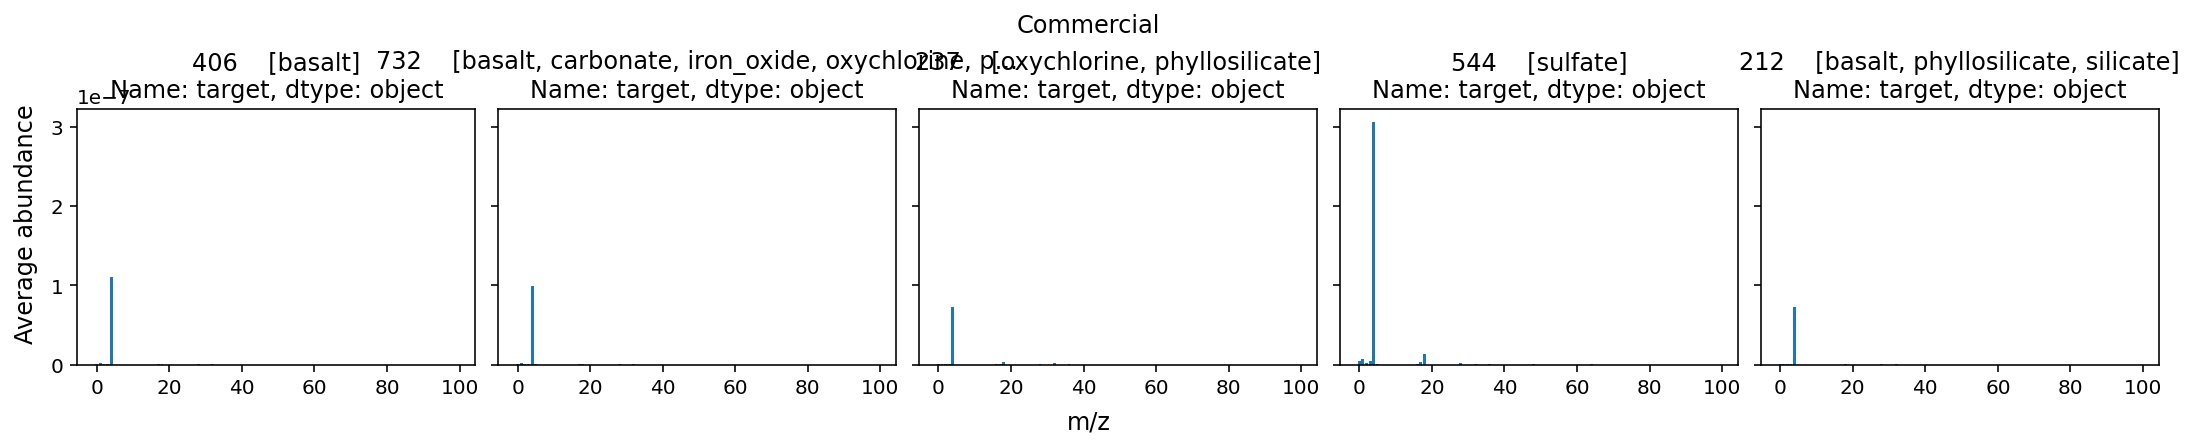

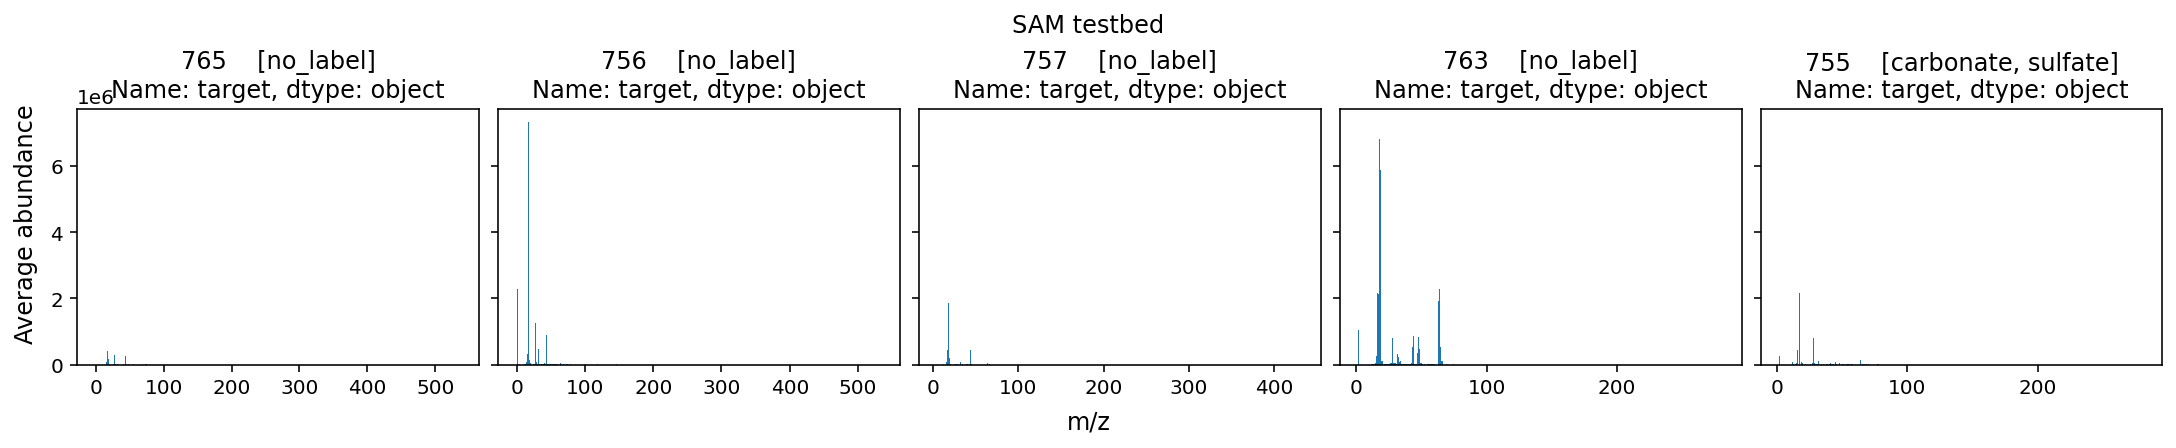

In [33]:
fig, ax = plt.subplots(1, len(sample_com), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Average abundance')
fig.supxlabel('m/z')
fig.suptitle('Commercial')

for n,i in enumerate(sample_com):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    target = train_labels[train_labels.sample_id == sample_name]['target']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    abd_sum = pd.DataFrame(df.groupby('m/z')['abundance'].agg('mean')).reset_index()
    plt.bar(abd_sum['m/z'], abd_sum['abundance'])
    plt.title(str(target))
plt.show()

fig, ax = plt.subplots(1, len(sample_sam), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Average abundance')
fig.supxlabel('m/z')
fig.suptitle('SAM testbed')

for n,i in enumerate(sample_sam):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    target = train_labels[train_labels.sample_id == sample_name]['target']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    abd_sum = pd.DataFrame(df.groupby('m/z')['abundance'].agg('mean')).reset_index()
    plt.bar(abd_sum['m/z'], abd_sum['abundance'])
    plt.title(str(target))
plt.show()
    

`m/z` values (from the benchmark notebook):
-  the range is not the same for all samples
- most samples are in the range on (0,99) -> discard m/z with the values above 99
- SAM testbeds samples contain fractional m/z values -> drop them as well
- `m/z=4` corresponds to the helium carrier gas (*A more sophisticated analysis could potentially use it to understand how other ions compare to it relatively.*)

In the following code we compute the range of the `m/z` values for each sample. We can see from the output that the majority of the samples have ion types in the range (0,99). Also, we can see that there are some fractional values and they are close to the integer values.

In [34]:
NO_SAMPLES = metadata.sample_id.nunique()
print(f'Number of samples = {NO_SAMPLES}')

cnt_mz_sample = {}
for i in range(NO_SAMPLES):
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    df = pd.read_csv(config.DATA_DIR + sample_file)
    cnt_mz_sample[sample_name] = pd.Interval(df['m/z'].min(), df['m/z'].max(), closed='both')
    
metadata['range_mz'] = metadata['sample_id'].map(cnt_mz_sample)

metadata['range_mz'].value_counts()

Number of samples = 1570


[0.0, 99.0]      1211
[0.0, 199.0]      161
[1.0, 60.0]        64
[2.0, 94.0]        48
[1.9, 281.0]       40
[5.0, 433.0]       11
[0.0, 534.0]        7
[0.0, 537.0]        6
[4.0, 64.0]         5
[14.0, 147.0]       3
[2.0, 64.0]         3
[13.9, 147.0]       3
[1.9, 147.0]        2
[5.0, 207.0]        2
[4.0, 78.0]         1
[4.0, 44.0]         1
[26.0, 197.0]       1
[1.9, 150.0]        1
Name: range_mz, dtype: int64

# PREPROCESSING

## Clean up `m/z` ion types

Preprocessing is composed of the following steps:
- remove all fractional ion types from each sample
- remove all ion types of value above 99
- `m/z=4` is discarded: it represents carrier gas (Helium) used in the experiments
- remove background levels of ions - bakcground noise

Function: `src.preprocess.preprocess_ion_type()`

To see the effect of the `preprocess_sample` on one sample we take sample which has range of `m/z` values `[0.0, 534.0]`.

['S0756' 'S1516' 'S1531' 'S1551' 'S1559' 'S1561' 'S1566']
Sample ID: S0756
(216349, 4)
(83272, 4)


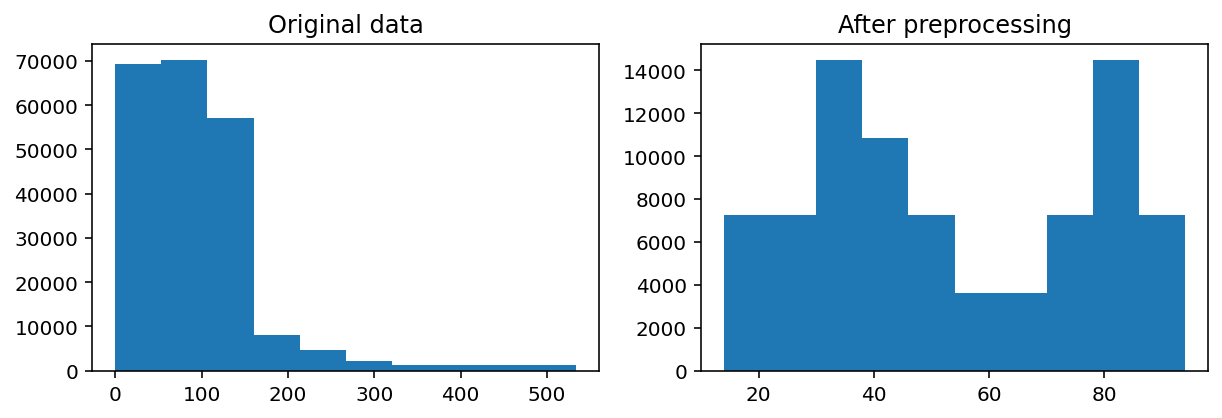

In [35]:
print(metadata[metadata.range_mz == pd.Interval(0.0, 534.0, closed='both')]['sample_id'].values)

ht = get_sample(756)
print(ht.shape)

ht1 = preprocess.preprocess_ion_type(df)
print(ht1.shape)

fig, ax = plt.subplots(1,2, figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(ht['m/z'])
plt.title('Original data')

plt.subplot(1,2,2)
plt.hist(ht1['m/z'])
plt.title('After preprocessing')
plt.show()

del ht, ht1

## Removing background ions

The most simplest way to remove the background levels of ions is to substract the minimum value.

> As mentioned in the project description, scientists may remove background noise more carefully. They may take an average of an area early in the experiment to subtract. Or, if the background noise varies over time, they may fit a function to it and subtract according to this function.

Function: `src.preprocess.remove_background_abundance()`

In [36]:
#TODO how to more efficienty remove background noise

## Compute relative abundance

> Since the relative abundances of various ions are more informative than their absolute values, we normalize the abundance values from 0 to 1 within a single sample.

Function: `src.preprocess.scale_abun()`

In [37]:
ht = get_sample(0)
print(ht.abundance.mean())
print(ht.abundance.min())
print(ht.abundance.max())

ht = preprocess.remove_background_abundance(ht)
print(ht.abundance_minsub.mean())

ht = preprocess.scale_abun(ht)
print(ht.abun_minsub_scaled.mean())
print(ht.abun_minsub_scaled.min())
print(ht.abun_minsub_scaled.max())

Sample ID: S0000
1.2976225343176853e-10
-5.866912e-14
3.604555e-08
5.212988348096544e-11
0.0015560655733099992
0.0
1.0


## Preprocess Pipeline

Function: `src.preprocess.preprocess_samples()`

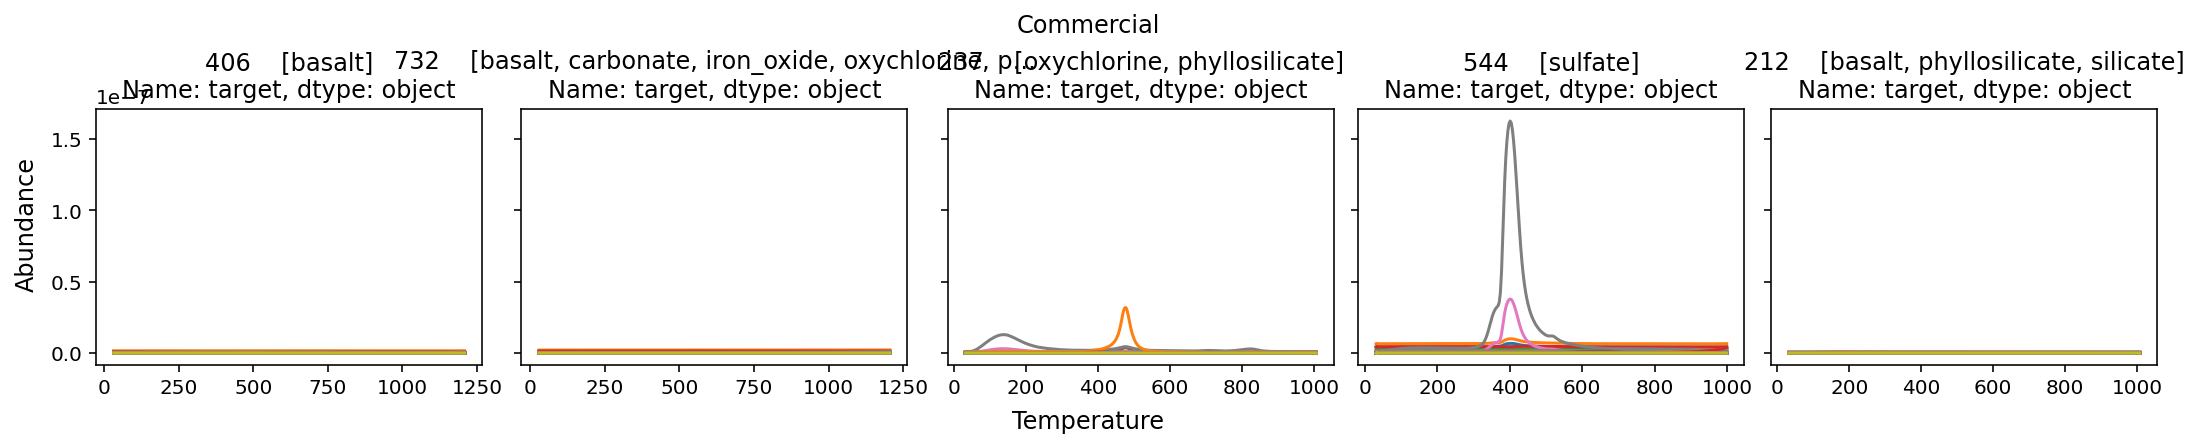

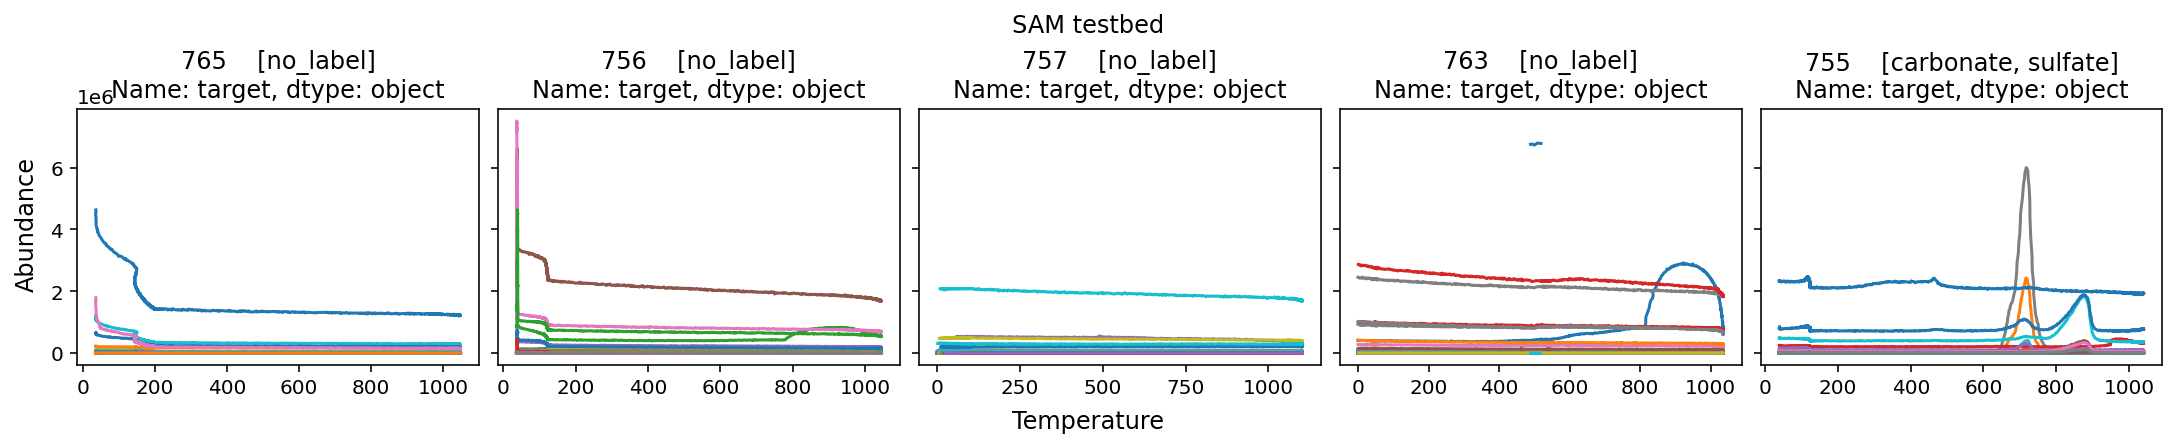

In [38]:
fig, ax = plt.subplots(1, len(sample_com), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Abundance')
fig.supxlabel('Temperature')
fig.suptitle('Commercial')

for n,i in enumerate(sample_com):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    target = train_labels[train_labels.sample_id == sample_name]['target']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    
    # Preprocess sample
    df = preprocess.preprocess_samples(df)
    
    plt.subplot(1, 5, n+1)
    for i in df['m/z'].unique():
        ht = df[df['m/z'] == i]
        plt.plot(ht['temp'], ht['abundance'])
    plt.title(str(target))
plt.show()

del ht

fig, ax = plt.subplots(1, len(sample_sam), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Abundance')
fig.supxlabel('Temperature')
fig.suptitle('SAM testbed')

for n,i in enumerate(sample_sam):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    target = train_labels[train_labels.sample_id == sample_name]['target']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    
    # Preprocess sample
    df = preprocess.preprocess_samples(df)
    
    plt.subplot(1, 5, n+1)
    for i in df['m/z'].unique():
        ht = df[df['m/z'] == i]
        plt.plot(ht['temp'], ht['abundance'])
    plt.title(str(target))
plt.show()
    

# FEATURE ENGINEERING

In the benchmark notebook the features are discretized into bins of 100 degrees.

In [39]:
#TODO How long does it take for temperature to rise to certain level where we get abundance?
#TODO How to account for the non-linear diferences of time vs temp?
#TODO Each type of ion as a feature, make a matrix and append to the training dataset
#TODO Max value of abundance of each ion - take temp reading and time - or duration
#TODO How to define characteristic of peaks in ion abundances; temp at which they occur, the shape of peaks (height, width, area)
#TODO How to deal with overlapping peaks
#TODO Number of peaks, size of the peaks
#TODO Can we do some target encoding?

# MODELING

In [10]:
train_files = metadata[metadata.split == 'train']['features_path'].values
valid_files = metadata[metadata.split == 'val']['features_path'].values
test_files = metadata[metadata.split == 'test']['features_path'].values

In [11]:
target_labels_list = [i for i in train_labels.columns if i not in ['sample_id']]
print(target_labels_list)

['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']


**FEATURE ENGINEERING**

In [ ]:
# Average temperature per sample
train = features.avg_temp_sample(train, train_files)
valid = features.avg_temp_sample(valid, valid_files)
test = features.avg_temp_sample(test, test_files)

## Benchmark - comp notebook

This benchmark is based on the [competition notebook](https://www.drivendata.co/blog/mars-spectrometry-benchmark/) solution.

> We will discretize the overall temperature range into bins (of 100 degrees), and calculate maximum relative abundance within that temperature bin for each m/z value.

In [13]:
def abun_per_tempbin(df):

    """
    Transforms dataset to take the preprocessed max abundance for each
    temperature range for each m/z value

    Args:
        df: dataframe to transform

    Returns:
        transformed dataframe
    """

    # Bin temperatures
    df["temp_bin"] = pd.cut(df["temp"], bins=temprange)

    # Combine with a list of all temp bin-m/z value combinations
    df = pd.merge(allcombs_df, df, on=["temp_bin", "m/z"], how="left")

    # Aggregate to temperature bin level to find max
    df = df.groupby(["temp_bin", "m/z"]).max("abun_minsub_scaled").reset_index()

    # Fill in 0 for abundance values without information
    df = df.replace(np.nan, 0)

    # Reshape so each row is a single sample
    df = df.pivot_table(columns=["m/z", "temp_bin"], values=["abun_minsub_scaled"])

    return df

In [14]:
# Create a series of temperature bins
temprange = pd.interval_range(start=-100, end=1500, freq=100)

# Make dataframe with rows that are combinations of all temperature bins
# and all m/z values
allcombs = list(itertools.product(temprange, [*range(0, 100)]))

allcombs_df = pd.DataFrame(allcombs, columns=["temp_bin", "m/z"])
allcombs_df.head()

# Assembling preprocessed and transformed training set

train_features_dict = {}
train_files = train['features_path'].to_dict()

print("Total number of train files: ", len(train_files))

for i, (sample_id, filepath) in enumerate(tqdm(train_files.items())):

    # Load training sample
    temp = pd.read_csv(config.DATA_DIR + filepath)

    # Preprocessing training sample
    train_sample_pp = preprocess.preprocess_samples(temp)

    # Feature engineering
    train_sample_fe = abun_per_tempbin(train_sample_pp).reset_index(drop=True)
    train_features_dict[sample_id] = train_sample_fe

train_features = pd.concat(
    train_features_dict, names=["sample_id", "dummy_index"]
).reset_index(level="dummy_index", drop=True)

# Make sure that all sample IDs in features and labels are identical
assert train_features.index.equals(train_labels.index)

Total number of train files:  766


100%|██████████| 766/766 [02:38<00:00,  4.84it/s]


In [28]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer

# Define stratified k-fold validation
skf = StratifiedKFold(n_splits=10, random_state=config.RANDOM_SEED, shuffle=True)

# Define log loss metric
log_loss_scorer = make_scorer(log_loss, needs_proba=True)

# Check log loss score for baseline dummy model
def logloss_cross_val(clf, X, y):

    # Generate a score for each label class
    log_loss_cv = {}
    for col in y.columns:

        y_col = y[col]  # take one label at a time
        log_loss_cv[col] = np.mean(
            cross_val_score(clf, X.values, y_col, cv=skf, scoring=log_loss_scorer)
        )

    avg_log_loss = np.mean(list(log_loss_cv.values()))

    return log_loss_cv, avg_log_loss

In [29]:
# Define logistic regression model
logreg_clf = LogisticRegression(
    penalty="l1", solver="liblinear", C=10, random_state=config.RANDOM_SEED
)
print("Logistic regression model log-loss:\n")
logreg_logloss = logloss_cross_val(logreg_clf, train_features, 
                                   train_labels[target_labels_list])
print(logreg_logloss[0])
print("Average log-loss")
logreg_logloss[1]

Logistic regression model log-loss:

{'basalt': 0.27667494614302185, 'carbonate': 0.261405355676578, 'chloride': 0.2842770277471818, 'iron_oxide': 0.38245389629312065, 'oxalate': 0.004103320117163466, 'oxychlorine': 0.2990978185052554, 'phyllosilicate': 0.40751189988765824, 'silicate': 0.35176540325465755, 'sulfate': 0.34463431214084367, 'sulfide': 0.147159858336199, 'no_label': 0.32298528832551127}
Average log-loss


0.28018810240247183

In [50]:
del train_features['instrument_type']

In [54]:
train_features = pd.concat([train_features, train['instrument_type']], axis = 1)
train_features.head()

,"(0, (-100, 0])","(0, (0, 100])","(0, (100, 200])","(0, (200, 300])","(0, (300, 400])","(0, (400, 500])","(0, (500, 600])","(0, (600, 700])","(0, (700, 800])","(0, (800, 900])",...,"(99, (600, 700])","(99, (700, 800])","(99, (800, 900])","(99, (900, 1000])","(99, (1000, 1100])","(99, (1100, 1200])","(99, (1200, 1300])","(99, (1300, 1400])","(99, (1400, 1500])",instrument_type
0,0.0,0.004085,0.004641,0.001394,0.000188,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,commercial
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,commercial
2,0.0,0.002270,0.002495,0.001688,0.000636,0.000597,0.000819,0.000155,0.000235,0.000227,...,9.397170e-07,0.000001,0.000001,0.000001,0.000000,0.0,0.0,0.0,0.0,commercial
3,0.0,0.001336,0.002464,0.001099,0.000992,0.000676,0.000883,0.000892,0.000631,0.000361,...,4.693477e-06,0.000004,0.000004,0.000004,0.000003,0.0,0.0,0.0,0.0,commercial
4,0.0,0.005993,0.012429,0.009380,0.005099,0.006921,0.001966,0.000499,0.000880,0.000767,...,3.174421e-06,0.000004,0.000004,0.000003,0.000004,0.0,0.0,0.0,0.0,commercial


In [52]:
# TEST MY CV TRAIN
clf = LogisticRegression(penalty="l1",solver="liblinear", C=10, random_state=config.RANDOM_SEED)
logloss = training.trainCV_label(train_features, train_labels, target_labels_list, 
                                        10, log_loss, clf)


LABEL: basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature nam


LABEL: carbonate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature nam


LABEL: chloride


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature nam


LABEL: iron_oxide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature nam


LABEL: oxalate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature nam


LABEL: oxychlorine


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature nam


LABEL: phyllosilicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature nam


LABEL: silicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature nam


LABEL: sulfate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature nam


LABEL: sulfide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature nam


LABEL: no_label


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature nam

In [ ]:
print(colored(f'Average Log Loss: {np.round(np.mean(list(logloss.values())), 4)}', 'blue'))
print('Log Loss per Label:')
logloss

## Tabular

### Average temperature, instrument

#### Logistic Regression

In [45]:
X = train[['instrument_type', 'avg_temp']].copy()
clf = LogisticRegression()
model_f1 = training.trainCV_label(X, train_labels, target_labels_list, 
                                  10, log_loss, clf)

print(colored(f'Average Log Loss: {np.round(np.mean(list(model_f1.values())), 4)}', 'magenta'))
print('Log Loss per Label:')
model_f1

Average Log Loss: 0.4031
Log Loss per Label:


{'basalt': 0.3653725188050637,
 'carbonate': 0.38219297476096203,
 'chloride': 0.36847979000477943,
 'iron_oxide': 0.5246182688346651,
 'oxalate': 0.16534049183935215,
 'oxychlorine': 0.5463372540738678,
 'phyllosilicate': 0.622962989096346,
 'silicate': 0.39480271375313647,
 'sulfate': 0.49351870116003427,
 'sulfide': 0.19254940669538345,
 'no_label': 0.37814055350232517}

#### KNeighbors

In [134]:
X = train[['instrument_type', 'avg_temp']].copy()
y = train_labels[target_labels_list].copy()

le = LabelEncoder()
X['instrument_type'] = le.fit_transform(X['instrument_type'].values)

knn_clf = KNeighborsClassifier()
y_train_preds = cross_val_predict(knn_clf, X, y, cv=3)
f1_score(y, y_train_preds, average="weighted")

0.26708443673489995

In [135]:
# TRAIN ON ALL DATA
X = train[['instrument_type', 'avg_temp']].copy()
y = train_labels[target_labels_list].copy()

le = LabelEncoder()
X['instrument_type'] = le.fit_transform(X['instrument_type'].values)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X, y)

KNeighborsClassifier()

Create a submission file:

In [136]:
XV = valid[['sample_id','instrument_type', 'avg_temp']].copy()
XT = test[['sample_id','instrument_type', 'avg_temp']].copy()

df_sub = pd.concat([XV, XT], ignore_index=True)
assert all(df_sub.sample_id == submission.sample_id)

del df_sub['sample_id']
df_sub['instrument_type'] = le.transform(df_sub['instrument_type'].values)
df_sub_preds = knn_clf.predict_proba(df_sub)


model_KNC = submission.copy()
for i in range(len(df_sub_preds)):
    model_KNC.iloc[:,i+1] = df_sub_preds[i][:,1]
    
print(model_KNC.head())

model_KNC.to_csv(config.MODELS_DIR + 'KNC_avgtemp.csv', index=False)

,sample_id,instrument_type,avg_temp
0,S0766,commercial,507.273978
1,S0767,commercial,610.137206


### Average abundance per ion

#### Logistic Regression

In [142]:
proba = features.ion_abundance(metadata, stats='max')

Number of samples: 766


In [143]:
X = proba.pivot(index='sample_id', columns='Ion_type',values='avg_abundance')
del proba
X = X.add_prefix('Ion_')
X = X.reset_index().rename_axis(None, axis=1)
assert all(X.sample_id == train_labels.sample_id)
X.drop('sample_id', axis = 1, inplace=True)
X = X.fillna(0)
print(X.shape)
X.head(2)

(766, 99)


,Ion_0.0,Ion_1.0,Ion_2.0,Ion_3.0,Ion_5.0,Ion_6.0,Ion_7.0,Ion_8.0,Ion_9.0,Ion_10.0,...,Ion_90.0,Ion_91.0,Ion_92.0,Ion_93.0,Ion_94.0,Ion_95.0,Ion_96.0,Ion_97.0,Ion_98.0,Ion_99.0
0,2.051983e-10,1.807573e-10,3.640491e-11,4.306694e-11,2.602803e-12,5.697595e-13,3.419571e-13,3.075363e-13,2.417060e-13,2.426013e-13,...,8.371576e-14,1.430587e-13,8.537706e-14,1.089228e-13,1.126763e-13,1.045660e-13,1.228644e-13,1.099377e-13,9.858141e-14,9.651079e-14
1,0.000000e+00,6.340000e-10,4.200000e-08,3.690000e-09,1.730000e-11,6.050000e-12,4.800000e-12,4.190000e-12,4.400000e-12,4.000000e-12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [144]:
clf = LogisticRegression(penalty="l1", solver="liblinear", C=10, 
                         random_state=config.RANDOM_SEED)
model_f2 = training.trainCV_label(X, 
                                  train_labels, target_labels_list, 
                                  10, log_loss, clf)

print(colored(f'Average Log Loss: {np.round(np.mean(list(model_f2.values())), 4)}', 'magenta'))
print('Log Loss per Label:')
model_f2

Average Log Loss: 0.4106
Log Loss per Label:


{'basalt': 0.3664808895653381,
 'carbonate': 0.4088756471250736,
 'chloride': 0.3678515397232987,
 'iron_oxide': 0.5238506574005068,
 'oxalate': 0.1647097591422796,
 'oxychlorine': 0.5627673909538957,
 'phyllosilicate': 0.6265013483118252,
 'silicate': 0.39489841545479976,
 'sulfate': 0.5009425946761422,
 'sulfide': 0.18880945798864301}

**Submission**

In [149]:
sample_list = valid['sample_id'].to_list()
XV = features.ion_abundance(metadata, 'max', sample_list)

sample_list = test['sample_id'].to_list()
XT = features.ion_abundance(metadata, 'max', sample_list)

Number of samples: 511


In [151]:
df_sub = pd.concat([XV, XT], ignore_index=True)
assert all(df_sub.sample_id == submission.sample_id)

ValueError: Can only compare identically-labeled Series objects

In [150]:
XT

,Ion_type,avg_abundance,sample_id
0,0.0,2.051983e-10,S1059
1,1.0,1.807573e-10,S1059
2,2.0,3.640491e-11,S1059
3,3.0,4.306694e-11,S1059
4,5.0,2.602803e-12,S1059
...,...,...,...
49253,95.0,2.822568e-13,S1569
49254,96.0,2.916454e-13,S1569
49255,97.0,2.722171e-13,S1569
49256,98.0,2.883587e-13,S1569


In [ ]:
XV = valid[['sample_id','instrument_type', 'avg_temp']].copy()
XT = test[['sample_id','instrument_type', 'avg_temp']].copy()

df_sub = pd.concat([XV, XT], ignore_index=True)
assert all(df_sub.sample_id == submission.sample_id)

del df_sub['sample_id']
df_sub['instrument_type'] = le.transform(df_sub['instrument_type'].values)
df_sub_preds = knn_clf.predict_proba(df_sub)


model_KNC = submission.copy()
for i in range(len(df_sub_preds)):
    model_KNC.iloc[:,i+1] = df_sub_preds[i][:,1]
    
print(model_KNC.head())

model_KNC.to_csv(config.MODELS_DIR + 'KNC_avgtemp.csv', index=False)

#### KNeighbors

In [39]:
y = train_labels[target_labels_list]
knn_clf = KNeighborsClassifier()
y_train_preds = cross_val_predict(knn_clf, X, y, cv=3)
f1_score(y, y_train_preds, average="weighted")

0.4957155544361905

## MY TEST

In [27]:
# Get min/max temperature values and unique ion list
# Preprocess the data to remove noise before calculation
min_temp, max_temp, ion_list = preprocess.compute_min_max_temp_ion(metadata)
print(colored(f'Min temp = {min_temp}; Max temp = {max_temp}', 'blue'))
print(colored(f'Number of unqiue ions: {len(ion_list)}', 'blue'))

100%|██████████| 1570/1570 [01:35<00:00, 16.51it/s]

Min temp = -63.563; Max temp = 1484.13
Number of unqiue ions: 99


In [12]:
# Compute max relative abundance for ion types and temp bins
sample_list = train.sample_id.values
train_features_ion_temp = features.features_iontemp_abun(metadata, sample_list)
print(f'Shape: {train_features_ion_temp.shape}')
train_features_ion_temp = train_features_ion_temp.fillna(0)
train_features_ion_temp

Number of samples: 766
Shape: (766, 1584)


,"Ion_0.0_(-100, 0]","Ion_0.0_(0, 100]","Ion_0.0_(100, 200]","Ion_0.0_(200, 300]","Ion_0.0_(300, 400]","Ion_0.0_(400, 500]","Ion_0.0_(500, 600]","Ion_0.0_(600, 700]","Ion_0.0_(700, 800]","Ion_0.0_(800, 900]",...,"Ion_99.0_(500, 600]","Ion_99.0_(600, 700]","Ion_99.0_(700, 800]","Ion_99.0_(800, 900]","Ion_99.0_(900, 1000]","Ion_99.0_(1000, 1100]","Ion_99.0_(1100, 1200]","Ion_99.0_(1200, 1300]","Ion_99.0_(1300, 1400]","Ion_99.0_(1400, 1500]"
0,0.0,0.004085,0.004641,0.001394,0.000188,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.002270,0.002495,0.001688,0.000636,0.000597,0.000819,0.000155,0.000235,0.000227,...,0.000001,9.397170e-07,0.000001,0.000001,0.000001,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.001336,0.002464,0.001099,0.000992,0.000676,0.000883,0.000892,0.000631,0.000361,...,0.000005,4.693477e-06,0.000004,0.000004,0.000004,0.000003,0.000000,0.0,0.0,0.0
4,0.0,0.005993,0.012429,0.009380,0.005099,0.006921,0.001966,0.000499,0.000880,0.000767,...,0.000005,3.174421e-06,0.000004,0.000004,0.000003,0.000004,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000086,7.136312e-05,0.000100,0.000086,0.000071,0.000071,0.000000,0.0,0.0,0.0
762,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000162,5.193249e-04,0.000097,0.000195,0.000162,0.000195,0.000000,0.0,0.0,0.0
763,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000184,2.757422e-04,0.000184,0.000184,0.000253,0.000253,0.000000,0.0,0.0,0.0
764,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000625,6.254950e-04,0.000625,0.000834,0.000834,0.001042,0.000625,0.0,0.0,0.0


In [19]:
# Rename columns
t_cols = train_features_ion_temp.columns
remove_chars = "(,]"
for char in remove_chars:
    t_cols = [i.replace(char,'') for i in t_cols]
t_cols = [i.replace(' ','_') for i in t_cols]
train_features_ion_temp.columns = t_cols

In [20]:
train_features_ion_temp

,Ion_0.0_-100_0,Ion_0.0_0_100,Ion_0.0_100_200,Ion_0.0_200_300,Ion_0.0_300_400,Ion_0.0_400_500,Ion_0.0_500_600,Ion_0.0_600_700,Ion_0.0_700_800,Ion_0.0_800_900,...,Ion_99.0_500_600,Ion_99.0_600_700,Ion_99.0_700_800,Ion_99.0_800_900,Ion_99.0_900_1000,Ion_99.0_1000_1100,Ion_99.0_1100_1200,Ion_99.0_1200_1300,Ion_99.0_1300_1400,Ion_99.0_1400_1500
0,0.0,0.004085,0.004641,0.001394,0.000188,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.002270,0.002495,0.001688,0.000636,0.000597,0.000819,0.000155,0.000235,0.000227,...,0.000001,9.397170e-07,0.000001,0.000001,0.000001,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.001336,0.002464,0.001099,0.000992,0.000676,0.000883,0.000892,0.000631,0.000361,...,0.000005,4.693477e-06,0.000004,0.000004,0.000004,0.000003,0.000000,0.0,0.0,0.0
4,0.0,0.005993,0.012429,0.009380,0.005099,0.006921,0.001966,0.000499,0.000880,0.000767,...,0.000005,3.174421e-06,0.000004,0.000004,0.000003,0.000004,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000086,7.136312e-05,0.000100,0.000086,0.000071,0.000071,0.000000,0.0,0.0,0.0
762,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000162,5.193249e-04,0.000097,0.000195,0.000162,0.000195,0.000000,0.0,0.0,0.0
763,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000184,2.757422e-04,0.000184,0.000184,0.000253,0.000253,0.000000,0.0,0.0,0.0
764,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000625,6.254950e-04,0.000625,0.000834,0.000834,0.001042,0.000625,0.0,0.0,0.0


**LOGISTIC REGRESSION**

In [95]:
# Train the model
clf = LogisticRegression(penalty="l1",solver="liblinear", C=10, random_state=config.RANDOM_SEED)
logloss_LR = training.trainCV_label(X = train_features_ion_temp, 
                                 df_y = train_labels, 
                                 target = target_labels_list, 
                                 cv_folds = 10, 
                                 model_metric = log_loss, 
                                 clf = clf)

# Print results
print(colored(f'Average Log Loss: {np.round(np.mean(list(logloss_LR.values())), 4)}', 'blue'))
print('Log Loss per Label:')
logloss_LR

Average Log Loss: 0.2759
Log Loss per Label:


{'basalt': 0.27678260590883075,
 'carbonate': 0.2612545003933846,
 'chloride': 0.2842979960325033,
 'iron_oxide': 0.3824699336087238,
 'oxalate': 0.004059239489520996,
 'oxychlorine': 0.2991500982787292,
 'phyllosilicate': 0.4074758334090647,
 'silicate': 0.35168474392654814,
 'sulfate': 0.34471883287139204,
 'sulfide': 0.14713584783404984}

**XGBOOST**  
- numerical data needs to be scaled
- categorical data needs to be encoded

In [30]:
# Train the model
clf = xgb.XGBClassifier(objective = "binary:logistic",
                        use_label_encoder = False,
                        eval_metric = 'logloss')
logloss_XGB = training.trainCV_label(X = train_features_ion_temp, 
                                 df_y = train_labels, 
                                 target = target_labels_list, 
                                 cv_folds = 10, 
                                 model_metric = log_loss, 
                                 clf = clf)


LABEL: basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


LABEL: carbonate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


LABEL: chloride


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


LABEL: iron_oxide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


LABEL: oxalate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


LABEL: oxychlorine


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


LABEL: phyllosilicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


LABEL: silicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


LABEL: sulfate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


LABEL: sulfide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

In [31]:
print(colored(f'Average Log Loss: {np.round(np.mean(list(logloss_XGB.values())), 4)}', 'blue'))
print('Log Loss per Label:')
logloss_XGB

Average Log Loss: 0.1934
Log Loss per Label:


{'basalt': 0.22565078102787242,
 'carbonate': 0.13225618815649615,
 'chloride': 0.22720553328986837,
 'iron_oxide': 0.254578396456081,
 'oxalate': 0.027906252811262605,
 'oxychlorine': 0.20850854126821824,
 'phyllosilicate': 0.29730870486992084,
 'silicate': 0.2575651139000811,
 'sulfate': 0.2245971262183839,
 'sulfide': 0.07831794841140914}

In [33]:
# Fit complete model
clf = xgb.XGBClassifier(objective = "binary:logistic",
                        use_label_encoder = False,
                        eval_metric = 'logloss')
clf_XGB = training.train_full_model(X = train_features_ion_temp,
                                    df_y = train_labels,
                                    target = target_labels_list,
                                    clf = clf)
# Predict valid & test

# Save to submission


LABEL: basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



LABEL: carbonate

LABEL: chloride

LABEL: iron_oxide

LABEL: oxalate

LABEL: oxychlorine

LABEL: phyllosilicate

LABEL: silicate

LABEL: sulfate


In [88]:
ht = preprocess.get_sample(metadata, 0)
ht = preprocess.preprocess_samples(ht)
print(ht[ht['abun_minsub_scaled'] == ht['abun_minsub_scaled'].max()])

        time     temp   m/z     abundance  abundance_minsub  \
8418  431.06  103.666  18.0  3.604555e-08      3.350108e-08   

      abun_minsub_scaled  
8418                 1.0  
          time     temp   m/z     abundance  abundance_minsub  \
19073  975.286  198.236  73.0  7.514823e-14      1.011009e-13   

       abun_minsub_scaled  
19073            0.000003  


In [ ]:
# Number of ions in the rel_abundance interval (0.8,1])